<br>
<h1 style="font-family:sans-serif; text-align:center"> 
<!--     <span style='color: pink'> Twitter analysis of </span> -->
    <span style='color: white; font-size:50%; text-shadow: 0px 0px 15px black'> Twitter analysis of </span>
<!--     <span style='color:#00acee'> Twitter analysis of </span> -->
<!--     <span style="-webkit-text-stroke"> Twitter analysis of</span> -->
<!--     <span class="hr3" style='color:#e40843; letter-spacing: 4px; font-size:105%'> Canada</span> -->
    <span class="hr3" style='color:#e40843; font-size:60%; text-shadow: 0px 0px 30px pink'>Canada </span> <span class="hr3" style='color:gray; font-size:50%; text-shadow: 0px 0px 30px pink'>response to Covid-19</span><br>
</h1>

# Analysis

The aim of this notebook is to analyze the retrieved tweets obtained using *snscrape*, from March 1st to April 30th of 2020, in order to analyze the difference in sentiment analysis of tweets from people befor and after Trudeau's [announcement of government policies facing impact of Covid-19](https://www.youtube.com/watch?v=1o-tV0A87l8&feature=youtu.be) to support small businesses and their employees.


_Authors: Leo Cuspinera ([cuspime](https://github.com/cuspime)) and Victor Cuspinera ([vcuspinera](https://github.com/vcuspinera))_

## Import libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta, date
from pytz import timezone
import json

# To plot
import altair as alt
alt.renderers.enable('mimetype')

# Preprocess libraries
import re
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Parameters

In [2]:
# dates
today = datetime.now()
init = date.fromisoformat('2020-03-01')

my_dates = list()
for d in range(0, 61, 1):
# for d in range(0, 1, 1):
    aux = init + timedelta(days=d)
    my_dates.append(aux)

# twitter accounts
accounts = ('JustinTrudeau', 'CanadianPM', 'Canada', 'GovCanHealth')

# max number of results
max_results = 100_000

#folder to save information
my_folder = "../tweets/"

## Open `json` file with all tweets

In [3]:
%%time

# Open the file
df_tot = pd.read_json(my_folder + 'tweets_db_clean.json')

CPU times: user 49.4 s, sys: 14.8 s, total: 1min 4s
Wall time: 1min 11s


## Basic analysis

In [4]:
# A first view of the data frame
df_tot.tail(3)

,account,date,replyCount,retweetCount,likeCount,quoteCount,lang,sourceLabel,username,followersCount,friendsCount,location,tweet
3503872,JustinTrudeau,2020-04-30 00:00:19,1,0,0,0,en,Twitter for iPhone,pffoote,356,1531,"St. John's, NL, Canada",@rcaf_arc @cfsnowbirds @canadianforces @cfoper...
3503873,JustinTrudeau,2020-04-30 00:00:18,0,0,0,0,hi,Twitter for Android,chandan24513630,1,40,,@narendramodi @justintrudeau who बौना होगा अगर...
3503874,JustinTrudeau,2020-04-30 00:00:08,0,0,0,0,en,Twitter Web App,DavidCBarron,231,331,Brampton Ontario,@cbcnews @ctvnews @justintrudeau @celliottabil...


In [5]:
# number of tweets
len(df_tot)

3503875

In [6]:
# Check if it contains the rigth tweets
%time df_tot.groupby(['account']).count()

CPU times: user 1.36 s, sys: 89.4 ms, total: 1.45 s
Wall time: 1.45 s


,date,replyCount,retweetCount,likeCount,quoteCount,lang,sourceLabel,username,followersCount,friendsCount,location,tweet
account,,,,,,,,,,,,
Canada,2711168,2711168,2711168,2711168,2711168,2711168,2711153,2711168,2711168,2711168,2711168,2711168
CanadianPM,35495,35495,35495,35495,35495,35495,35495,35495,35495,35495,35495,35495
GovCanHealth,24549,24549,24549,24549,24549,24549,24549,24549,24549,24549,24549,24549
JustinTrudeau,732663,732663,732663,732663,732663,732663,732663,732663,732663,732663,732663,732663


In [7]:
df_tot.describe()

,replyCount,retweetCount,likeCount,quoteCount,followersCount,friendsCount
count,3.503875e+06,3.503875e+06,3.503875e+06,3.503875e+06,3.503875e+06,3.503875e+06
mean,7.788797e-01,2.055384e+00,7.387272e+00,2.483151e-01,1.964345e+04,1.606954e+03
std,1.424193e+01,9.179367e+01,3.873542e+02,1.508036e+01,4.094871e+05,7.620145e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.900000e+01,1.710000e+02
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.550000e+02,5.230000e+02
75%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.835000e+03,1.450000e+03
max,7.498000e+03,9.977500e+04,4.676340e+05,1.500900e+04,8.380480e+07,1.441770e+06


In [8]:
# See the number of unique terms per each variable
df_tot.nunique()

account                 4
date              2338472
replyCount            681
retweetCount         1391
likeCount            2759
quoteCount            444
lang                   62
sourceLabel          6264
username          1069132
followersCount      65596
friendsCount        21186
location           223513
tweet             3060973
dtype: int64

In [9]:
# tweets by `Account`
print("Number of tweets by Account:\n")
pd.DataFrame(df_tot['account'].value_counts())

Number of tweets by Account:



,account
Canada,2711168
JustinTrudeau,732663
CanadianPM,35495
GovCanHealth,24549


In [10]:
# tweets by `language`
languages_twitter = pd.read_csv(my_folder + "twitter_supported_languages.csv", skiprows=5)
languages_twitter

print("Number of tweets by Languages:")
print("  -- the most used ones --\n")
data_langs = pd.DataFrame(df_tot['lang'].value_counts().head()).\
            reset_index().rename(columns={'index':'Language_code', 'lang':'tweets'})

# languages_twitter
pd.merge(languages_twitter, data_langs, how="right", on=["Language_code", "Language_code"])


Number of tweets by Languages:
  -- the most used ones --



,Language_code,Name,tweets
0,en,English (default),2915145
1,es,Spanish,212901
2,fr,French,135014
3,und,NaN,91355
4,pt,Portuguese,48713


## EDA
_Exploratory Data Analysis_

In [11]:
%%time

# add column with day
df_tot['day'] = [df_tot['date'][i].strftime("%Y-%m-%d") for i in range(len(df_tot))]

CPU times: user 1min 24s, sys: 70.3 ms, total: 1min 24s
Wall time: 1min 24s


### Tweets per day by account

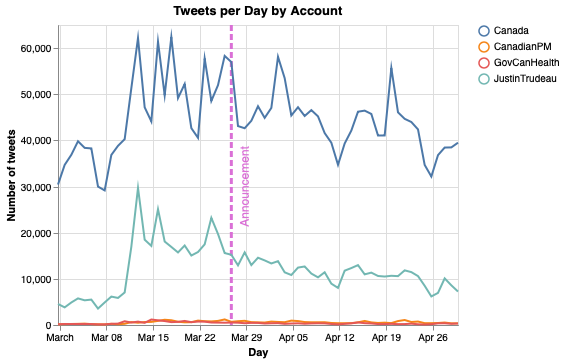

In [12]:
df_aux = pd.DataFrame(df_tot.groupby(['account', 'day'])['tweet'].count()).reset_index()

base = alt.Chart(df_aux)

lines = base.mark_line().encode(
    x = alt.X('day:T', title="Day"),
    y = alt.Y('tweet:Q', title="Number of tweets"),
    color = alt.Color('account')#, title="Account")
).properties(
    title='Tweets per Day by Account'
)

rule = alt.Chart(pd.DataFrame({
    'day': ['2020-03-27'],
    'color': ['orchid']
})).mark_rule(size=3, strokeDash=[6,3]).encode(
  x='day:T',
  color=alt.Color('color:N', scale=None, title = "")
)

text = alt.Chart(pd.DataFrame({
    'day': ['2020-03-29'],
    'color': ['orchid'],
    'y': [30000]
})).mark_text(
    text='Announcement', angle=270, size=12
).encode(
    x='day:T', y='y',
    color=alt.Color('color:N', scale=None, title = "")
)

rule + lines + text

### Proportion of tweets for each Account by Language

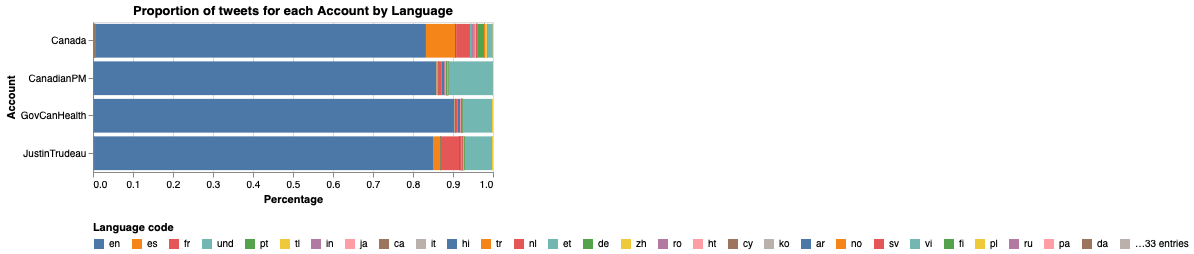

In [13]:
df_aux = pd.DataFrame(df_tot.groupby(['account', 'lang'])['tweet'].count()).reset_index()
sort_lang = pd.DataFrame(df_aux.groupby(['lang'])['tweet'].sum()).reset_index().sort_values(by=['tweet'], ascending=False).reset_index()['lang']

alt.Chart(df_aux).mark_bar().encode(
    x=alt.X('sum(tweet)', stack="normalize", title="Percentage"),
    y=alt.Y('account', title="Account"),
    color=alt.Color('lang', sort=sort_lang.to_list(), title="Language code", legend=alt.Legend(orient="bottom")),
    tooltip=['account' , 'lang']
).properties(
    title='Proportion of tweets for each Account by Language',
    height=150
)


### Users with most tweets that mention/or are related with the official Canadian accounts.

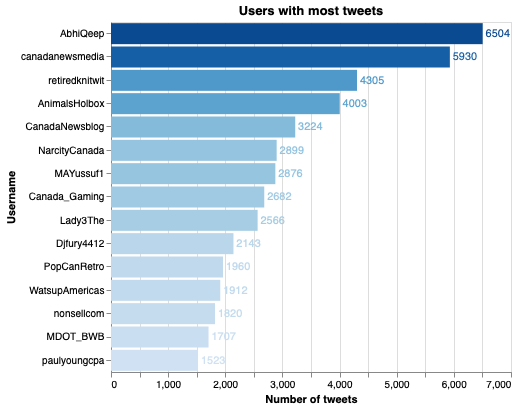

In [14]:
df_aux = pd.DataFrame(df_tot.groupby(['username'])['tweet'].count()).reset_index().sort_values(by=['tweet'], ascending=False).reset_index(drop=True)

bars = alt.Chart(df_aux[:15]).mark_bar().encode(
    x=alt.X('tweet', title="Number of tweets"),
    y=alt.Y('username', sort=list(df_aux['username'][:15]), title="Username"),
    color=alt.Color('tweet', legend=None)
).properties(
    title='Users with most tweets'
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='tweet:Q'
)

(bars + text).properties(height=350)

### Tokens per tweet distribution

In [15]:
# count the tokens per tweets
%time tweet_size = [len(tweet) for tweet in df_tot['tweet']]

CPU times: user 563 ms, sys: 15.6 ms, total: 579 ms
Wall time: 578 ms


In [16]:
source = pd.DataFrame(tweet_size).reset_index().rename(columns = {0:"tokens", 'index': "counts"})
source = source.groupby(['tokens']).count().reset_index()
source

,tokens,counts
0,0,276
1,1,39
2,2,10
3,3,22
4,4,22
...,...,...
974,991,1
975,992,1
976,999,1
977,1003,1


In [17]:
base = alt.Chart(source).mark_line().encode(
#     x=alt.X("tokens:Q"),#, bin=True),
    x=alt.X("tokens:Q"),#, bin=alt.Bin(maxbins=100), title="Number of tokens (binned)"),
    y=alt.Y('counts', title="Count of records")
).properties(
    title='Histogram of number of tokens by tweet'
)

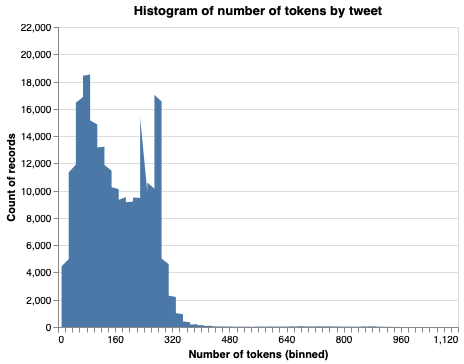

In [18]:
histo = base.mark_area().encode(x=alt.X("tokens:Q", bin=alt.Bin(maxbins=70), title="Number of tokens (binned)"))
#line = base.transform_regression('tokens', 'counts', method="poly", order=1).mark_line(size=4, color="salmon")
histo

### Analysis by location

In [19]:
pd.DataFrame(df_tot.groupby(['location'])['tweet'].count()).reset_index().sort_values(by=['tweet'], ascending=False).reset_index(drop=True)

,location,tweet
0,,974993
1,Canada,204791
2,"Toronto, Ontario",92833
3,"Ontario, Canada",62237
4,Toronto,48435
...,...,...
223508,Republik of Buffalo,1
223509,Republik Seakan2,1
223510,Dumpster outside Disneyland,1
223511,Republiek Amsterdam,1


The location of the tweets depends on description manually given by the user. It looks ambiguous and probably is not very useful for this analysis.

### Heatmap with number of tweets per day by official Canada account

In [20]:
# wrangling data
source = df_tot.groupby(['account', 'day'])['tweet'].count().reset_index()
aux_tot = df_tot.groupby(['account'])['tweet'].count().reset_index().rename(columns = {'tweet': 'total'})

# auxiliar dataframe
df_aux = pd.merge(source, aux_tot, on='account', how='left')
df_aux['weight'] = df_aux['tweet']/df_aux['total']
df_aux.head()

,account,day,tweet,total,weight
0,Canada,2020-03-01,30429,2711168,0.011224
1,Canada,2020-03-02,34689,2711168,0.012795
2,Canada,2020-03-03,36879,2711168,0.013603
3,Canada,2020-03-04,39812,2711168,0.014684
4,Canada,2020-03-05,38378,2711168,0.014156


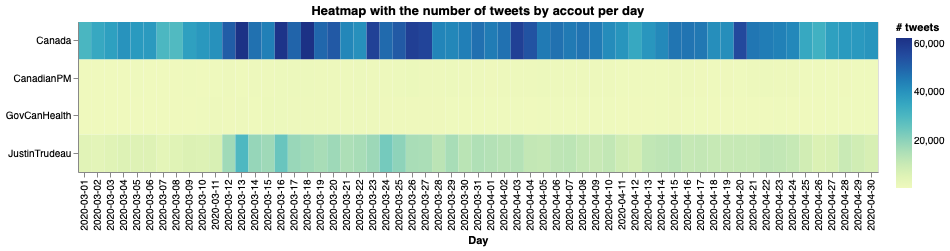

In [28]:
# heatmap with the number of tweets by accout, per day
base = alt.Chart(df_aux).mark_rect().encode(
    x=alt.X('day:O', title="Day"),
    y=alt.Y('account:O', title=""),
    color=alt.Color('tweet:Q', title="# tweets")
).properties(height=150, width=800)

base.properties(title='Heatmap with the number of tweets by accout per day')

With this heatmap we can identify the accounts with most tweets, but it is not as useful for identidying the days with more tweets for the accounts _CanadianPM_ and _GovCanHealth_.

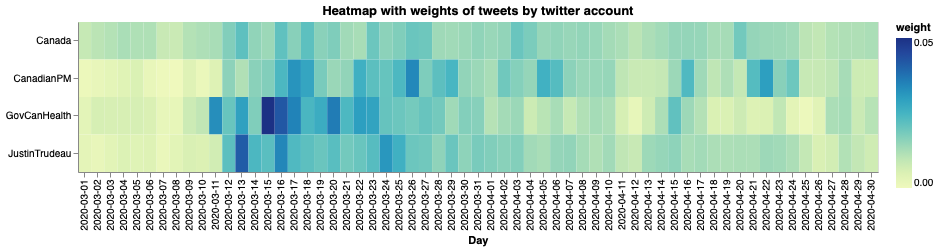

In [29]:
# use a heatmap to show the number of tweets by accout, per day
base.encode(color='weight').properties(title='Heatmap with weights of tweets by twitter account')

In the previous heatmap we normalize the number of tweets by each Twitter account. With this plot, we can identify a higher number of tweets for all twitter accounts between March 12 and March 29, 2020.  

In [ ]:
df_tot.head(3)